### Bistable wilson and cowan like model

from : https://elifesciences.org/articles/22425#fig5

In [2]:
# for fast array manipulation
import numpy as np
# for plotting
import matplotlib.pyplot as plt
# for numerical ODE integration
from scipy.integrate import solve_ivp
# to display plots in-line
%matplotlib inline
plt.style.use('ggplot')

In [3]:
def sigmoid(x, a, thr):
    return 1 / (1 + np.exp(-a * (x - thr)))

def threshold_linear(x,thr,gain):
    thresholded = x-thr
    if thresholded > 0:
        return gain*thresholded
    else:
        return 0 

vthreshold_linear = np.vectorize(threshold_linear)

In [4]:
# Time constant of neural pop in seconds
tau_e = 0.010
tau_i = 0.002
tau_a = 0.5
# Synapse strength
j_ee = 5
j_ei = 1
j_eiw = j_ei
j_ie = 10
j_iwe = 5
j_ii = 0.5
j_rec = 1.5
# Adaptation parameter
beta = 6
tau_a = 0.5
# threshold and gains
g_e = 1
g_i = 4
thr_i = 25
thr_e = 3 # to play with
# Input currents
I_e = 6
# I_e-thr_e = 3 which is equivalent to taking I_e = 0 and thr_e = -3 as in the paper 
plas_ie = 0.1
plas_iwe = 0.1
plas_ei = 0.3
plas_eiw = 0.3
exc_increase = 0.003
inhib_decay = 0.03
target_inhib = 8
target_inhib_wide = target_inhib
target_exc = 4
target_total_exc = 4.1

# Network structure parameters

nb_per_pool = 2

In [18]:
# this function returns the right hand side of the Wilson-Cowan equation
# (both, in a 2-vector)
def rate_model(t,y ,N):
    
    # data structure  :
    # N is the number of pool, n is the actual pool we are looking at.
    # y[(7*n)+0]  = E
    # y[(7*n)+1] = I
    # y[(7*n)+2] = A
    # y[(7*n)+3] = J_ie
    # y[(7*n)+4] = J_ei
    # y[(7*n)+5] = J_eiw
    # y[(7*n)+6] = J_iwe
    # y[(7*(N-1))+7] : the activity of the long range inhibitory unit inducing competition

    y_out = np.zeros((N*7)+1)
    sum_exc_target = np.zeros(N) # summed excitation comming to an excitatory neuron
    # sum_exc_inh = np.array(N) # summed excitation comming to an inhibitory neuron
    Iw = y[(7*(N-1))+7]
    sum_exc_Iw = 0 # summed excitation comming to the wide inhitory neuron
    sum_exc = 0

    # The first loop gather the summed excitation (and or inhibition) comming from all sources to a target.
    for n1 in range(N):

        for n2 in range(N):
            E2 = y[(7*n2)+0] 
            if n1 == n2:
                sum_exc_target[n1]+= E2*j_ee
            else :
                sum_exc_target[n1]+= E2*j_rec

        E1 = y[(7*n1)+0]
        J_iwe = y[(7*n1)+6]
        sum_exc_Iw += E1 * J_iwe
        sum_exc += E1

    
    for n in range(N):

        E = y[(7*n)+0] 
        I = y[(7*n)+1] 
        A = y[(7*n)+2] 
        J_ie = y[(7*n)+3]
        J_ei = y[(7*n)+4]
        J_eiw = y[(7*n)+5]
        J_iwe = y[(7*n)+6]
        exc_drive = sum_exc_target[n]

        y_out[(7*n)+0] = (-E + vthreshold_linear(exc_drive-J_eiw*Iw-J_ei*I-A+I_e,thr_e, g_e))/tau_e
        y_out[(7*n)+1] = (-I + vthreshold_linear(J_ie*E-j_ii*I,thr_i,g_i))/tau_i
        y_out[(7*n)+2] = (-A + beta*E)/tau_a

        #Synaptic plasticity

        if J_ie<0:
            y_out[(7*n)+3] = -J_ie
        else : 
            y_out[(7*n)+3] = -(((I-target_inhib)>0)*E*plas_ie)+exc_increase

        if J_ei<0:
            y_out[(7*n)+4] = -J_ei
        else : 
            y_out[(7*n)+4] = (((E-target_exc)>0)*I*plas_ei)-inhib_decay
        
        if J_eiw<0:
            y_out[(7*n)+5] = -J_eiw
        else : 
            y_out[(7*n)+5] = (((sum_exc-target_total_exc)>0)*Iw*plas_eiw)-inhib_decay

        if J_iwe<0 :
            y_out[(7*n)+6] = -J_iwe
        else :
            y_out[(7*n)+6] = -(((Iw-target_inhib_wide)>0)*E*plas_iwe)+exc_increase
    
    y_out[(7*(N-1))+7] = (-Iw + vthreshold_linear(sum_exc_Iw-j_ii*Iw,thr_i,g_i))/tau_i

    return y_out



In [38]:
# simulation duration and step size
time = np.linspace(0, 1000, int(2020056/3))
N = 3

y0 = np.zeros((N*7)+1)
print(y0)
for n in range(N):
    y0[(7*n)+0] = 0
    y0[(7*n)+1] = 0

    # One neuron start with less adaptation to be sure to go out of equilibrium
    if n == 0:
        y0[(7*n)+2] = 0
    else :
        y0[(7*n)+2] = 1

    y0[(7*n)+3] = j_ie
    y0[(7*n)+4] = j_ei
    y0[(7*n)+5] = j_eiw
    y0[(7*n)+6] = j_iwe

y0[(7*(N-1))+7] = 0

# find the solution with scint.odeint
odesol = solve_ivp(rate_model,[0,1000], y0,args=(N,) , t_eval=time)

# separate the two solutions
#exc_ts, exc2_ts, inh_ts,inh2_ts,inh3_ts, a_ts, a2_ts, j_ie_ts,j_i2e2_ts,j_i3e_ts,j_i3e2_ts,j_ei_ts,j_e2i2_ts,j_ei3_ts,j_e2i3_ts = odesol.y

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


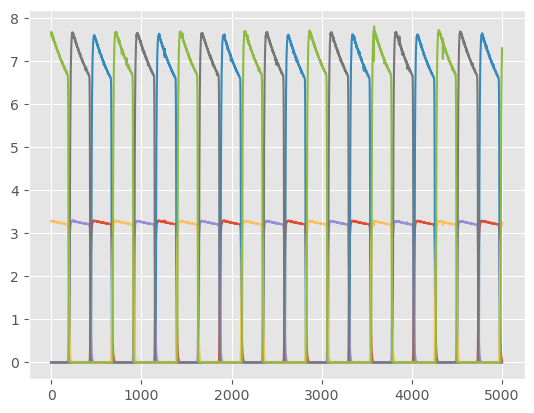

In [39]:
plt.plot(odesol.y[(7*0)+0][-5000:])
plt.plot(odesol.y[(7*0)+1][-5000:])
plt.plot(odesol.y[(7*1)+0][-5000:])
plt.plot(odesol.y[(7*1)+1][-5000:])
plt.plot(odesol.y[(7*2)+0][-5000:])
plt.plot(odesol.y[(7*2)+1][-5000:])

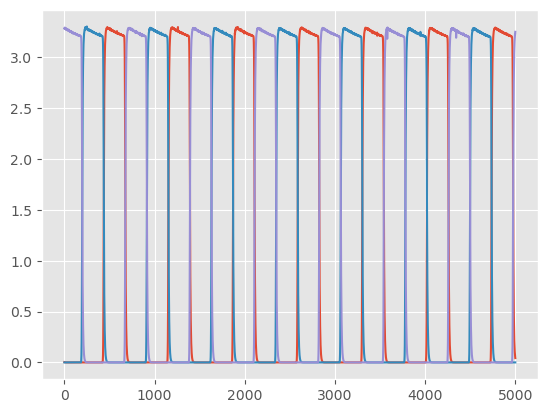

In [40]:
plt.plot(odesol.y[(7*0)+0][-5000:])
plt.plot(odesol.y[(7*1)+0][-5000:])
plt.plot(odesol.y[(7*2)+0][-5000:])

In [41]:
len(odesol.y[(7*0)+0])

673352

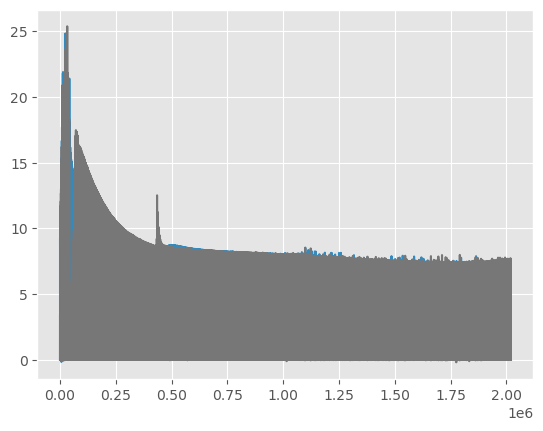

In [24]:
plt.plot(odesol.y[(7*0)+0])
plt.plot(odesol.y[(7*0)+1])
plt.plot(odesol.y[(7*1)+0])
plt.plot(odesol.y[(7*1)+1])

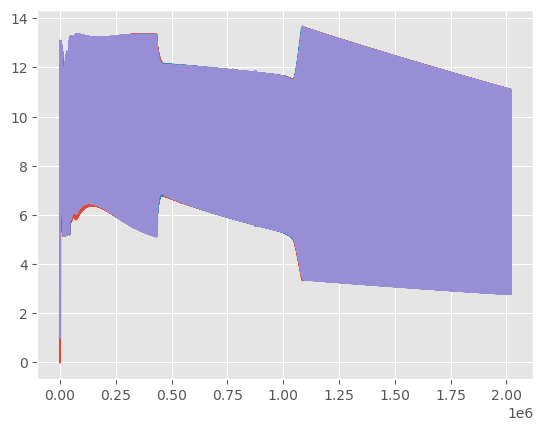

In [31]:
plt.plot(odesol.y[(7*0)+2]);
plt.plot(odesol.y[(7*1)+2]);
plt.plot(odesol.y[(7*2)+2]);

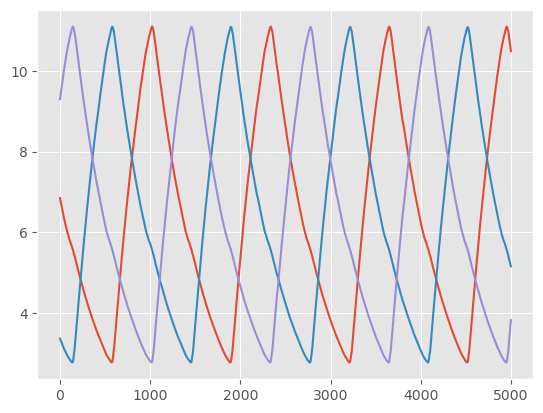

In [29]:
plt.plot(odesol.y[(7*0)+2][-5000:]);
plt.plot(odesol.y[(7*1)+2][-5000:]);
plt.plot(odesol.y[(7*2)+2][-5000:]);

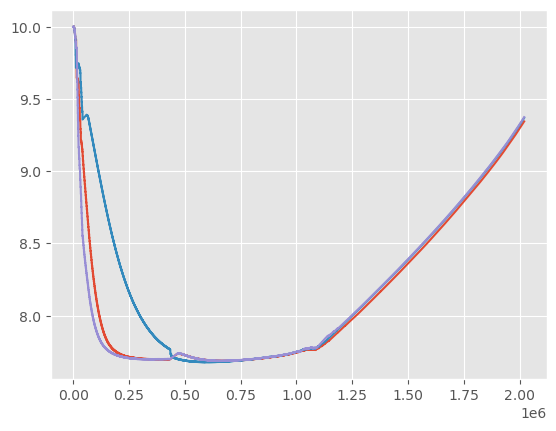

In [32]:
plt.plot(odesol.y[(7*0)+3]);
plt.plot(odesol.y[(7*1)+3]);
plt.plot(odesol.y[(7*2)+3]);
#plt.plot(inh_ts[-5000:]);

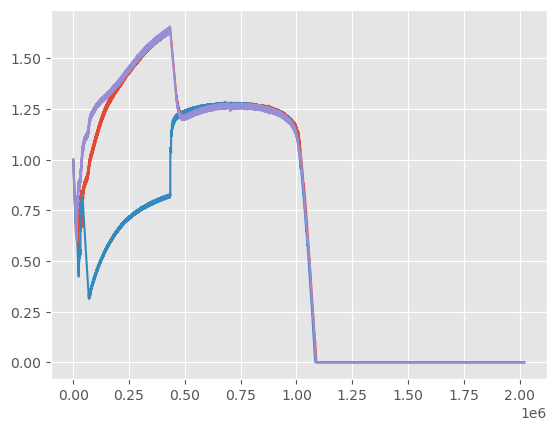

In [33]:
plt.plot(odesol.y[(7*0)+4]);
plt.plot(odesol.y[(7*1)+4]);
plt.plot(odesol.y[(7*2)+4]);

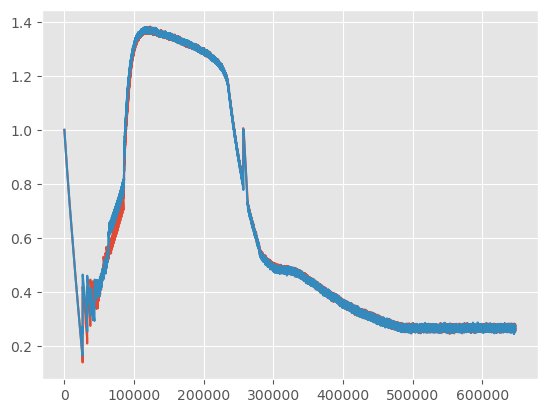

In [82]:
plt.plot(j_ei_ts);
plt.plot(j_e2i2_ts);

In [83]:
# # plotting the vector field in the state space (E, I)
# plt.figure(figsize=(10, 10))
# #plt.quiver(x2[:,:,49], x1[:,:,49], X2[:,:,49], X1[:,:,49], pivot='mid', alpha=.5)
# plt.xlim([minval, maxval])
# plt.ylim([minval, maxval])
# plt.xlabel(r'$I$', fontsize=16) # yes, you can use Latex code!
# plt.ylabel(r'$E$', fontsize=16)
# plt.grid()

# # plot the solution in the state space
# plt.plot(inh_timeseries, exc_timeseries, '.-');

# # plot the fixed points we identified
# plt.scatter(fixed_p[1], fixed_p[0], marker='o', c='k', s=50,
#             label="Stationary points")

# # plot the starting point
# plt.scatter(I0, E0, marker='*', c='r', s=300, label="Starting point")
# plt.legend(loc="upper left")

# # plot the solution in time
# plt.figure(figsize=(10.3,3))
# plt.ylabel(r'$E, I$')
# plt.xlabel(r'$t$')
# plt.plot(time, exc_timeseries, '.-', label="excitatory");
# plt.plot(time, inh_timeseries, '.-', label="inhibitory");
# plt.legend();